# Vibration-Based Condition Monitoring
## Learning-Based Diagnostics — Hankel Matrix, HI & LHI

**Author:** Bradley Paul Nast  
**Module:** MEV781 — Vibration Based Condition Monitoring  
**University:** University of Pretoria  

---

This notebook presents a **learning-based alternative** to the classical signal processing pipeline demonstrated in notebooks 1 and 2. Rather than relying on TSA, spectral kurtosis, and envelope analysis, this approach uses linear algebra — specifically Principal Component Analysis (PCA) applied to a Hankel matrix representation of the vibration signal — to derive health indicators directly from the raw signal.

Two health indicators are derived and compared:

- **Health Indicator (HI)** — reconstruction error from PCA, capturing deviation from the healthy signal subspace
- **Latent Health Indicator (LHI)** — L2 norm in the PCA latent space, amplifying signal-to-noise ratio through dimensionality reduction

Both are evaluated on a **healthy** and **unhealthy** gearbox signal and compared against the classical signal processing approach.

---
## 0. Imports & Configuration

In [1]:
import numpy as np
import scipy.io as sio
from scipy.fft import fft, fftfreq
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import urllib.request
import io

# Plot styling
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})

print('Libraries loaded.')

Libraries loaded.


---
## 1. Load Data & System Parameters

In [2]:
# ── Load .mat file from GitHub ────────────────────────────────────────────────
url = 'https://raw.githubusercontent.com/0xBPNast/data-science-portfolio/main/projects/condition-monitoring/data/mev_a2_q3_data.mat'

with urllib.request.urlopen(url) as response:
    data = sio.loadmat(io.BytesIO(response.read()))

# Extract signals — signal_one is healthy, signal_two is unhealthy
signal_healthy   = data['signal_one'].squeeze()
signal_unhealthy = data['signal_two'].squeeze()

# Extract sampling parameters
fs_vib   = data['Fs'].item()         # Vibration sampling frequency [Hz]
fs_tacho = data['Fs_tacho'].item()   # Tachometer sampling frequency [Hz]
PPR      = data['ppr'].item()        # Tachometer pulses per revolution

print(f'Vibration Fs      : {fs_vib} Hz')
print(f'Tacho Fs          : {fs_tacho} Hz')
print(f'PPR               : {PPR}')
print(f'Signal length     : {len(signal_healthy)} samples ({len(signal_healthy)/fs_vib:.2f} s)')
print(f'Healthy range     : [{signal_healthy.min():.3f}, {signal_healthy.max():.3f}]')
print(f'Unhealthy range   : [{signal_unhealthy.min():.3f}, {signal_unhealthy.max():.3f}]')

Vibration Fs      : 25000 Hz
Tacho Fs          : 45000 Hz
PPR               : 10
Signal length     : 100000 samples (4.00 s)
Healthy range     : [-40.923, 40.202]
Unhealthy range   : [-66.627, 75.348]


In [3]:
# ── System fault frequencies — SKF 6206 at 600 RPM ───────────────────────────
RPM  = 600
fr   = RPM / 60      # Shaft rotational frequency [Hz]
GMF  = fr * 30       # Gear meshing frequency [Hz]
BPFO = 35.500        # Ball Pass Frequency, Outer Race [Hz]
BPFI = 54.318        # Ball Pass Frequency, Inner Race [Hz]
FTF  = 3.965         # Fundamental Train Frequency [Hz]

print(f'Shaft frequency : {fr:.2f} Hz')
print(f'GMF             : {GMF:.2f} Hz')
print(f'BPFO            : {BPFO:.3f} Hz')
print(f'BPFI            : {BPFI:.3f} Hz')
print(f'FTF             : {FTF:.3f} Hz')

Shaft frequency : 10.00 Hz
GMF             : 300.00 Hz
BPFO            : 35.500 Hz
BPFI            : 54.318 Hz
FTF             : 3.965 Hz


---
## Part 1 — Hankel Matrix Construction

The raw vibration signal is structured into a **Hankel matrix** using a sliding window of length `Lw` with step size `Lsft`. Each row of the matrix contains one windowed segment of the signal.

This representation exploits the time-delayed embedding of the signal — the matrix captures the temporal structure of the vibration in a form suitable for PCA decomposition.

In [4]:
def Hankel_matrix(signal, Lw=512, Lsft=1):
    """
    Construct a Hankel matrix from a vibration signal.

    Slides a window of length Lw across the signal with step Lsft,
    storing each windowed segment as a row. The resulting matrix
    captures the time-delayed embedding of the signal and is used
    as input to PCA for health indicator derivation.

    Parameters
    ----------
    signal : array — input vibration signal (1D)
    Lw     : int   — window length in samples (default 512)
    Lsft   : int   — window shift/step in samples (default 1)

    Returns
    -------
    Hmat : array — Hankel matrix of shape (n_windows, Lw)
    """
    N    = len(signal)
    Lh   = int((N - Lw) / Lsft) + 1
    Hmat = np.zeros((Lh, Lw))

    for i in range(Lh):
        start       = int(i * Lsft)
        end         = int(Lw + i * Lsft)
        Hmat[i, :]  = signal[start:end]

    return Hmat


def reconstruction_error(X, Xrecon):
    """
    Health Indicator (HI) via PCA reconstruction error.

    Computes the sum of squared differences between the original
    Hankel matrix rows and their PCA reconstructions. High error
    indicates signal content not captured by the healthy subspace.

    Parameters
    ----------
    X      : array — original Hankel matrix (n_windows, Lw)
    Xrecon : array — PCA-reconstructed Hankel matrix (n_windows, Lw)

    Returns
    -------
    HI_error : array — reconstruction error per window (n_windows,)
    """
    ms       = np.subtract(X, Xrecon)
    HI_error = (ms ** 2).sum(axis=1)
    return HI_error


def latent_norm(Z):
    """
    Latent Health Indicator (LHI) via PCA latent space norm.

    Computes the L2 norm squared of each row in the PCA latent
    space. PCA amplifies the signal-to-noise ratio through
    covariance decomposition, making fault frequencies more
    visible than in the raw HI.

    Parameters
    ----------
    Z : array — PCA latent space representation (n_windows, n_components)

    Returns
    -------
    LHI : array — latent norm per window (n_windows,)
    """
    LHI = (Z ** 2).sum(axis=1)
    return LHI

In [5]:
# ── Build Hankel matrices ─────────────────────────────────────────────────────
LW   = 512   # Window length [samples]
LSFT = 1     # Window shift [samples]

print('Building Hankel matrices...')
H_healthy   = Hankel_matrix(signal_healthy,   Lw=LW, Lsft=LSFT)
H_unhealthy = Hankel_matrix(signal_unhealthy, Lw=LW, Lsft=LSFT)

print(f'Healthy Hankel shape   : {H_healthy.shape}')
print(f'Unhealthy Hankel shape : {H_unhealthy.shape}')

Building Hankel matrices...
Healthy Hankel shape   : (99489, 512)
Unhealthy Hankel shape : (99489, 512)


---
## Part 2 — PCA & Health Indicator Derivation

PCA is fitted on the **healthy** Hankel matrix to define the healthy signal subspace. Both healthy and unhealthy matrices are then projected through this same PCA model:

- **HI** — reconstruction error when projecting back from the PCA subspace to the original space. Unhealthy signal content that falls outside the healthy subspace produces high reconstruction error.
- **LHI** — L2 norm of the latent space projection. PCA's covariance decomposition inherently amplifies the signal-to-noise ratio, making fault frequency content more visible in the LHI than the HI.

In [6]:
# ── Fit PCA on healthy signal ─────────────────────────────────────────────────
N_COMPONENTS = 10   # Number of principal components to retain

pca = PCA(n_components=N_COMPONENTS)
pca.fit(H_healthy)

print(f'PCA components          : {N_COMPONENTS}')
print(f'Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}')
print(f'Per component           : {np.round(pca.explained_variance_ratio_, 4)}')

PCA components          : 10
Explained variance ratio: 0.5966
Per component           : [0.1413 0.1402 0.0754 0.0736 0.039  0.0388 0.032  0.031  0.0127 0.0126]


In [7]:
# ── Project both signals through healthy PCA model ────────────────────────────

# Healthy signal
Z_healthy        = pca.transform(H_healthy)               # Latent space projection
H_healthy_recon  = pca.inverse_transform(Z_healthy)       # Reconstruction

# Unhealthy signal — projected through the SAME healthy PCA model
Z_unhealthy        = pca.transform(H_unhealthy)
H_unhealthy_recon  = pca.inverse_transform(Z_unhealthy)

# ── Compute HI and LHI ────────────────────────────────────────────────────────
HI_healthy    = reconstruction_error(H_healthy,   H_healthy_recon)
HI_unhealthy  = reconstruction_error(H_unhealthy, H_unhealthy_recon)

LHI_healthy   = latent_norm(Z_healthy)
LHI_unhealthy = latent_norm(Z_unhealthy)

print(f'HI  healthy   — mean: {HI_healthy.mean():.4f},  max: {HI_healthy.max():.4f}')
print(f'HI  unhealthy — mean: {HI_unhealthy.mean():.4f},  max: {HI_unhealthy.max():.4f}')
print(f'LHI healthy   — mean: {LHI_healthy.mean():.4f},  max: {LHI_healthy.max():.4f}')
print(f'LHI unhealthy — mean: {LHI_unhealthy.mean():.4f},  max: {LHI_unhealthy.max():.4f}')

HI  healthy   — mean: 21158.4256,  max: 25874.2710
HI  unhealthy — mean: 26379.3685,  max: 37499.8468
LHI healthy   — mean: 31293.4030,  max: 41577.2712
LHI unhealthy — mean: 31577.5662,  max: 41351.2448


---
## Part 3 — HI & LHI Time Domain Analysis

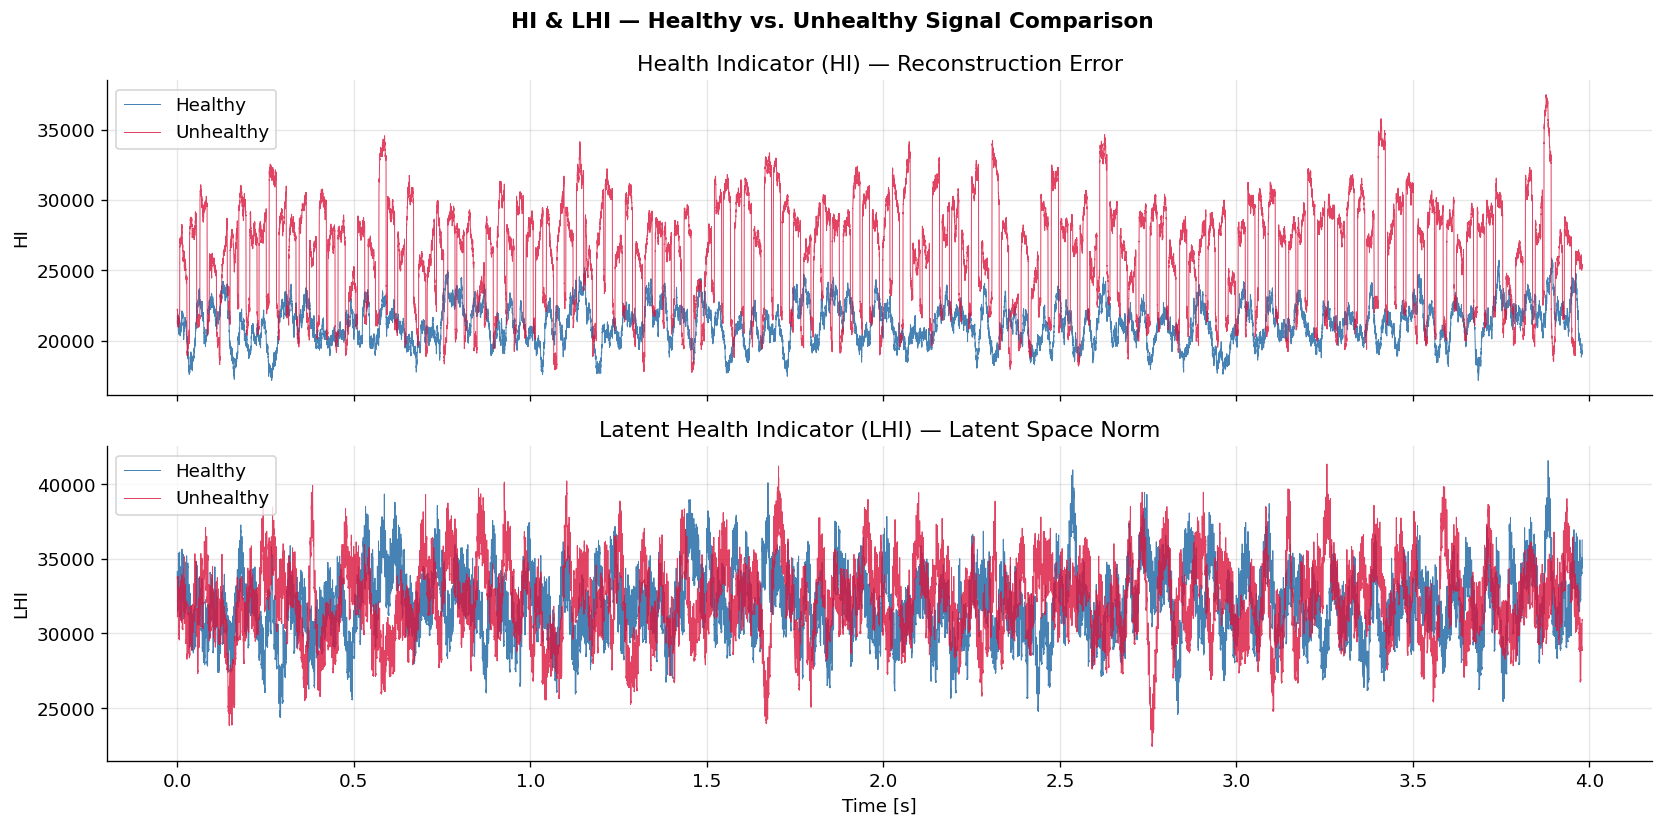

In [8]:
# ── Time axes for HI/LHI (one value per window, offset by Lw/2) ───────────────
t_hi = np.arange(len(HI_healthy)) * LSFT / fs_vib

# ── Plot HI — healthy vs unhealthy ────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axes[0].plot(t_hi, HI_healthy,   color='steelblue',  lw=0.6, label='Healthy')
axes[0].plot(t_hi, HI_unhealthy, color='crimson',    lw=0.6, alpha=0.8, label='Unhealthy')
axes[0].set_title('Health Indicator (HI) — Reconstruction Error')
axes[0].set_ylabel('HI')
axes[0].legend()

axes[1].plot(t_hi, LHI_healthy,   color='steelblue', lw=0.6, label='Healthy')
axes[1].plot(t_hi, LHI_unhealthy, color='crimson',   lw=0.6, alpha=0.8, label='Unhealthy')
axes[1].set_title('Latent Health Indicator (LHI) — Latent Space Norm')
axes[1].set_ylabel('LHI')
axes[1].set_xlabel('Time [s]')
axes[1].legend()

plt.suptitle('HI & LHI — Healthy vs. Unhealthy Signal Comparison',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

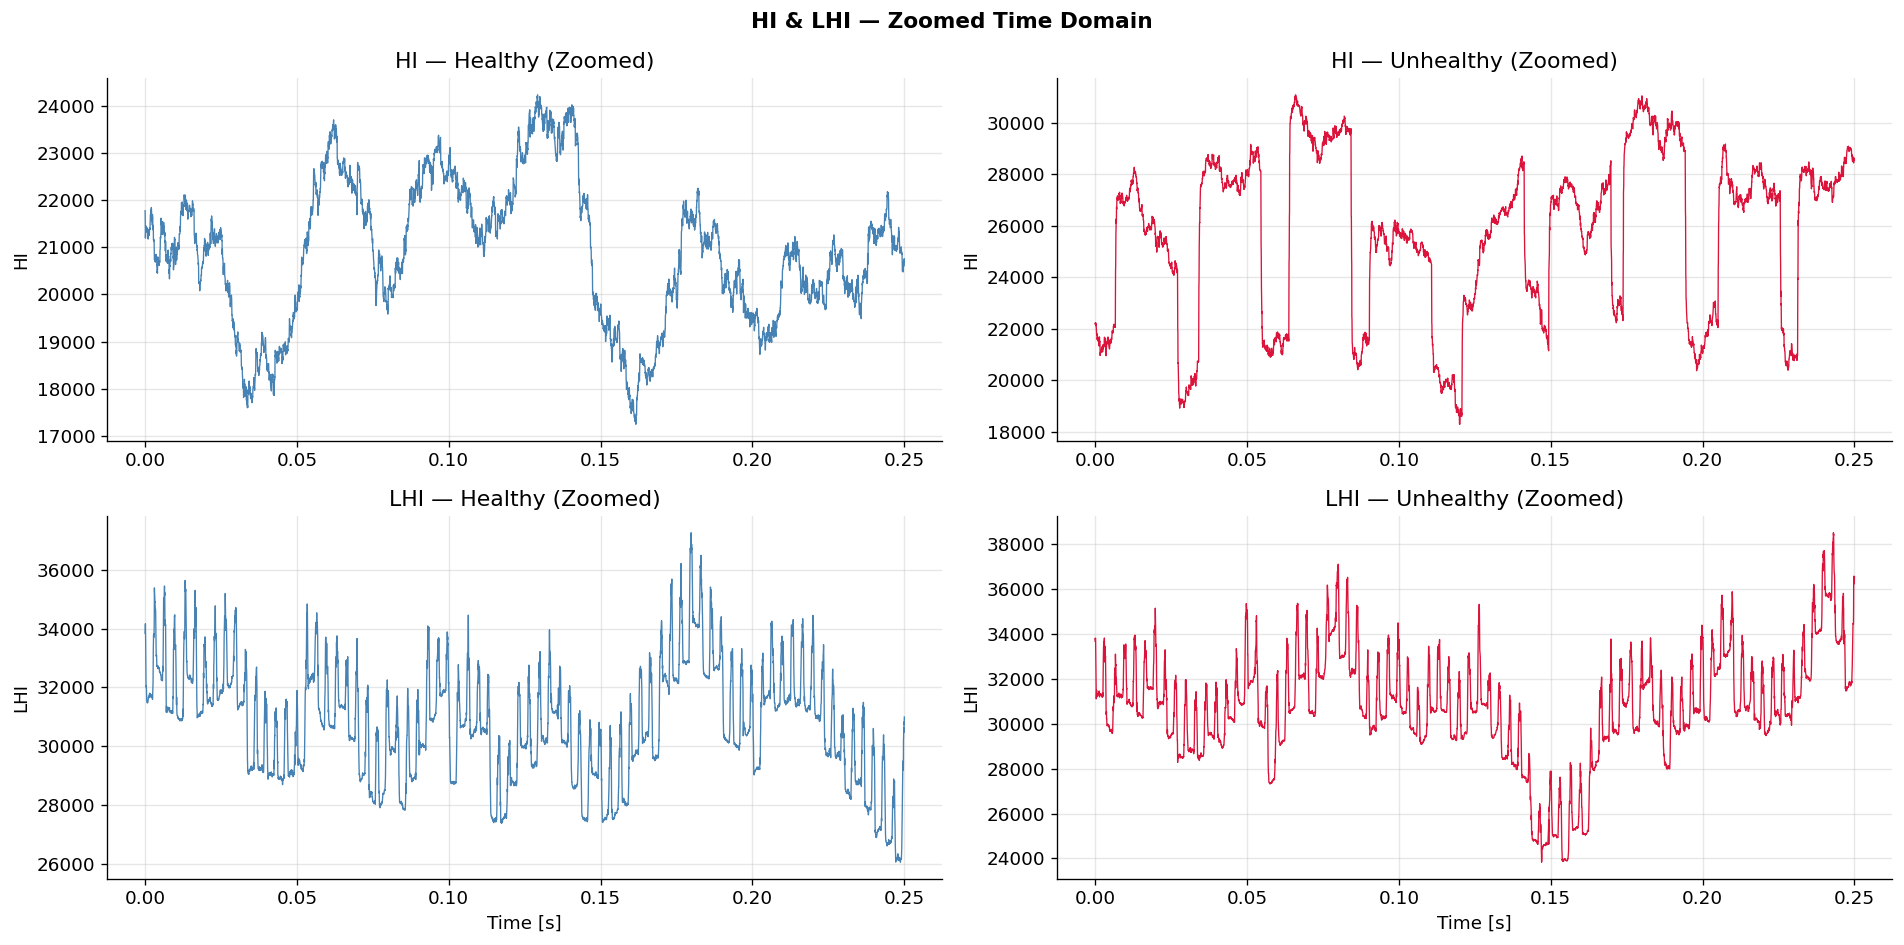

In [9]:
# ── Zoomed time domain — inspect periodic fault content ───────────────────────
ZOOM_START = 0.0    # seconds — adjust to region of interest
ZOOM_END   = 0.25   # seconds

zoom_mask = (t_hi >= ZOOM_START) & (t_hi <= ZOOM_END)

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# HI zoomed
axes[0, 0].plot(t_hi[zoom_mask], HI_healthy[zoom_mask],   color='steelblue', lw=0.8)
axes[0, 0].set_title('HI — Healthy (Zoomed)')
axes[0, 0].set_ylabel('HI')

axes[0, 1].plot(t_hi[zoom_mask], HI_unhealthy[zoom_mask], color='crimson',   lw=0.8)
axes[0, 1].set_title('HI — Unhealthy (Zoomed)')
axes[0, 1].set_ylabel('HI')

# LHI zoomed
axes[1, 0].plot(t_hi[zoom_mask], LHI_healthy[zoom_mask],   color='steelblue', lw=0.8)
axes[1, 0].set_title('LHI — Healthy (Zoomed)')
axes[1, 0].set_ylabel('LHI')
axes[1, 0].set_xlabel('Time [s]')

axes[1, 1].plot(t_hi[zoom_mask], LHI_unhealthy[zoom_mask], color='crimson',   lw=0.8)
axes[1, 1].set_title('LHI — Unhealthy (Zoomed)')
axes[1, 1].set_ylabel('LHI')
axes[1, 1].set_xlabel('Time [s]')

plt.suptitle('HI & LHI — Zoomed Time Domain',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 4 — HI & LHI Frequency Analysis

Frequency analysis of the HI and LHI reveals whether bearing and gear fault frequencies are preserved through the learning-based process. The LHI is expected to show cleaner fault frequency peaks than the HI due to the improved signal-to-noise ratio from PCA.

In [10]:
def compute_spectrum(signal, fs):
    """
    Single-sided FFT magnitude spectrum.

    Parameters
    ----------
    signal : array — input signal
    fs     : float — sampling frequency [Hz]

    Returns
    -------
    freqs    : array — frequency axis [Hz]
    spectrum : array — normalised magnitude spectrum
    """
    N        = len(signal)
    spectrum = np.abs(fft(signal)) / N
    freqs    = fftfreq(N, 1 / fs)
    half     = N // 2
    return freqs[:half], spectrum[:half]


# HI sampling frequency — one sample per LSFT samples of original signal
fs_hi = fs_vib / LSFT

# Compute spectrums
f_hi_h,  s_hi_h  = compute_spectrum(HI_healthy,   fs_hi)
f_hi_uh, s_hi_uh = compute_spectrum(HI_unhealthy, fs_hi)
f_lhi_h,  s_lhi_h  = compute_spectrum(LHI_healthy,   fs_hi)
f_lhi_uh, s_lhi_uh = compute_spectrum(LHI_unhealthy, fs_hi)

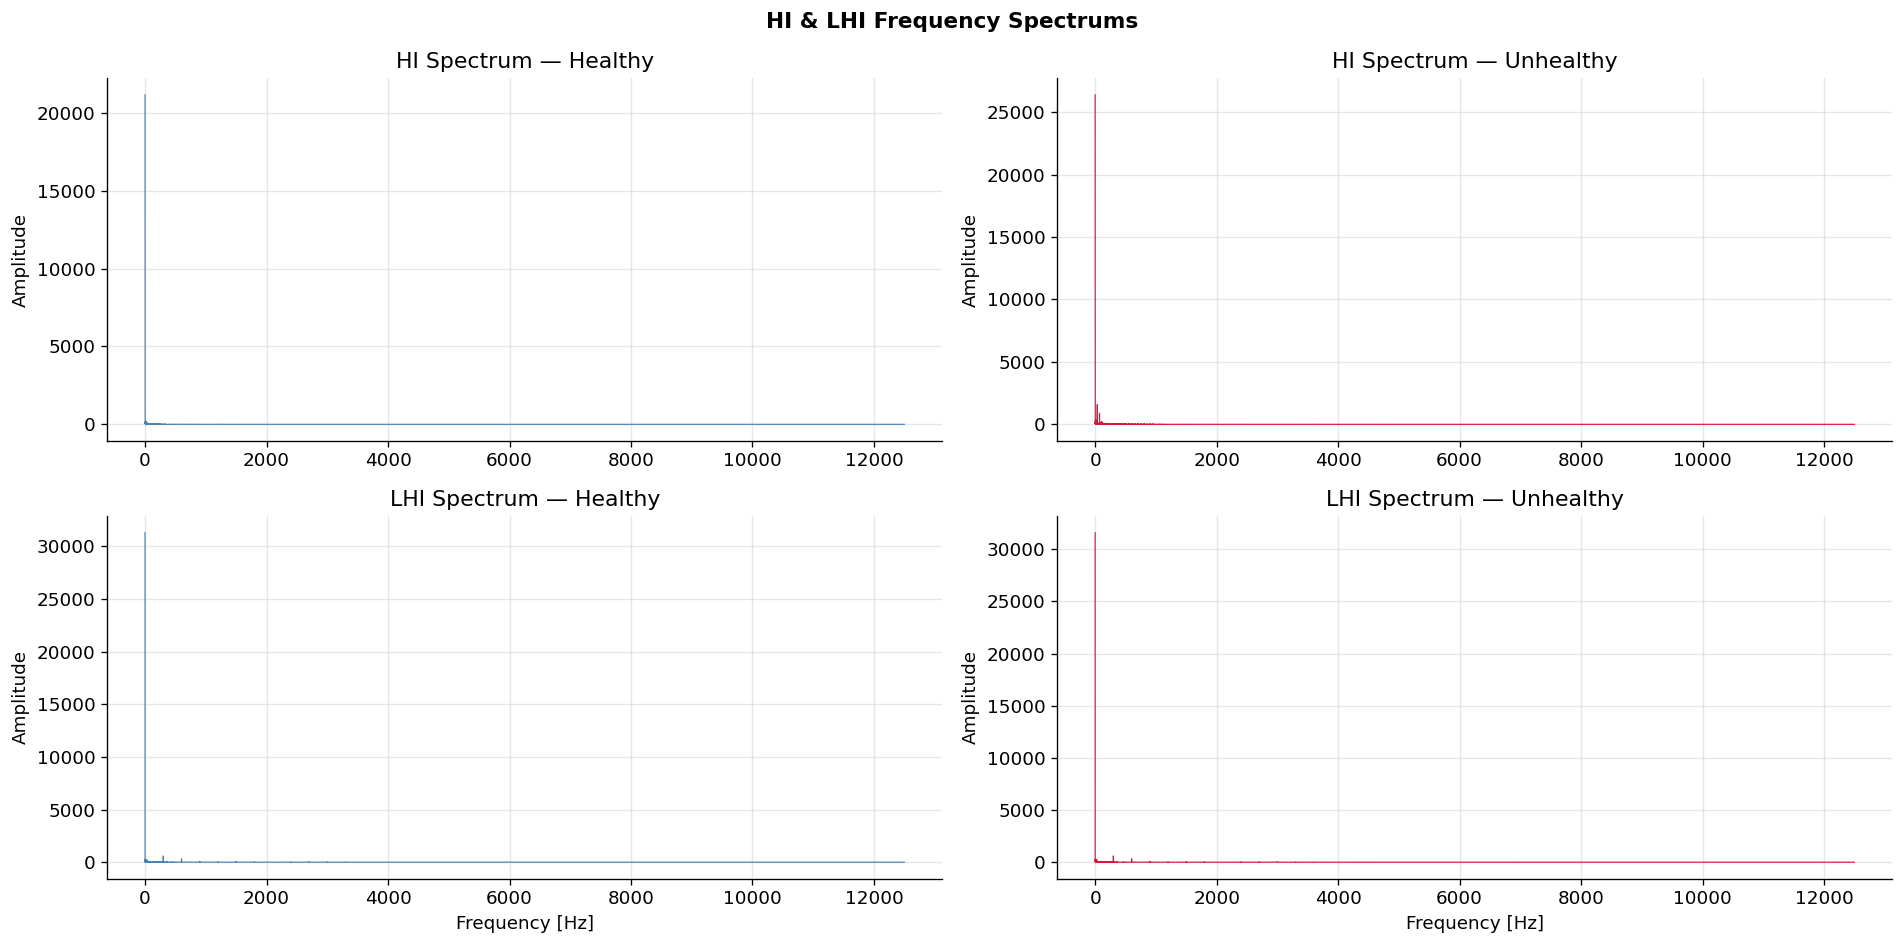

In [11]:
# ── Plot full frequency spectrums ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

axes[0, 0].plot(f_hi_h,   s_hi_h,   color='steelblue', lw=0.7)
axes[0, 0].set_title('HI Spectrum — Healthy')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(f_hi_uh,  s_hi_uh,  color='crimson',   lw=0.7)
axes[0, 1].set_title('HI Spectrum — Unhealthy')
axes[0, 1].set_ylabel('Amplitude')

axes[1, 0].plot(f_lhi_h,  s_lhi_h,  color='steelblue', lw=0.7)
axes[1, 0].set_title('LHI Spectrum — Healthy')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_xlabel('Frequency [Hz]')

axes[1, 1].plot(f_lhi_uh, s_lhi_uh, color='crimson',   lw=0.7)
axes[1, 1].set_title('LHI Spectrum — Unhealthy')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_xlabel('Frequency [Hz]')

plt.suptitle('HI & LHI Frequency Spectrums', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

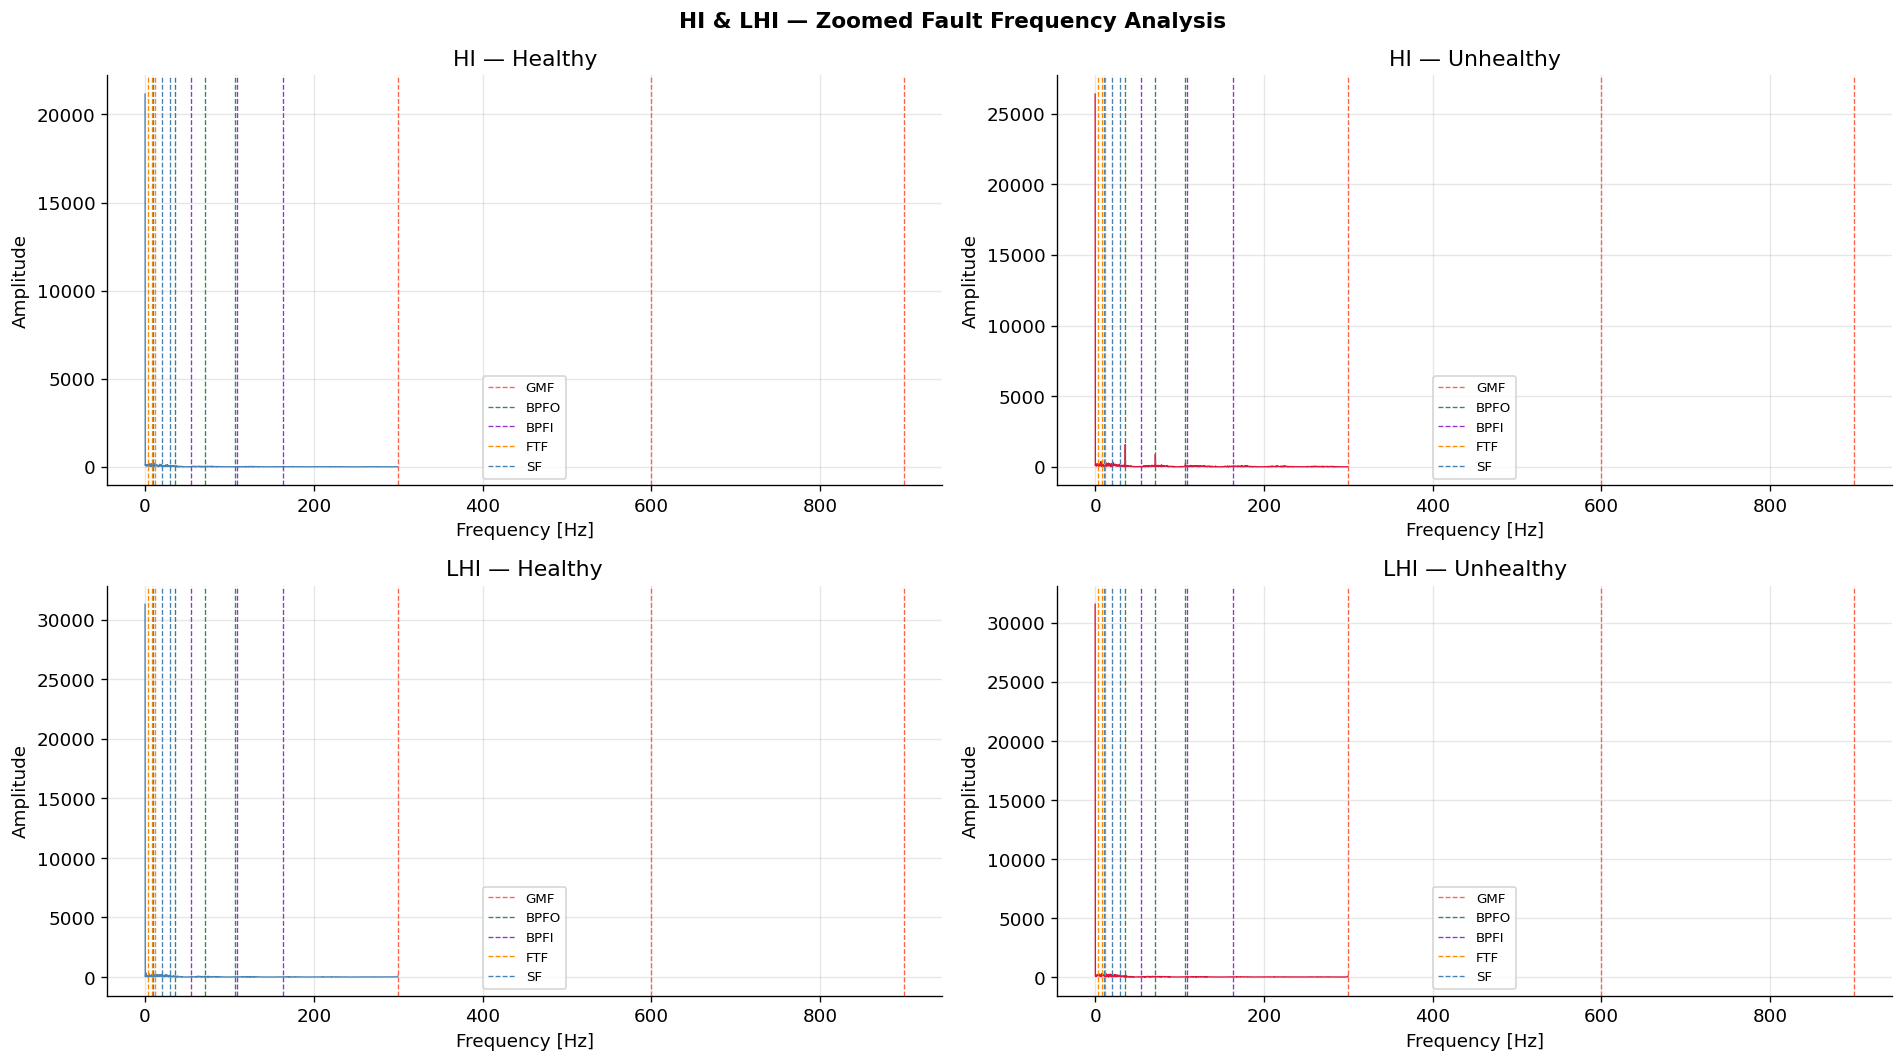

In [12]:
# ── Zoomed spectrum — bearing & gear fault frequency range ────────────────────
ZOOM_FREQ = 300   # Hz — covers bearing fault frequencies and GMF

# Fault frequency markers
fault_freqs = {
    'GMF' : (GMF,  'tomato'),
    'BPFO': (BPFO, 'seagreen'),
    'BPFI': (BPFI, 'darkorchid'),
    'FTF' : (FTF,  'darkorange'),
    'SF'  : (fr,   'steelblue')
}

fig, axes = plt.subplots(2, 2, figsize=(16, 9))

for ax, freqs, spectrum, title in [
    (axes[0, 0], f_hi_h,   s_hi_h,   'HI — Healthy'),
    (axes[0, 1], f_hi_uh,  s_hi_uh,  'HI — Unhealthy'),
    (axes[1, 0], f_lhi_h,  s_lhi_h,  'LHI — Healthy'),
    (axes[1, 1], f_lhi_uh, s_lhi_uh, 'LHI — Unhealthy')
]:
    zoom = freqs <= ZOOM_FREQ
    ax.plot(freqs[zoom], spectrum[zoom], color='steelblue' if 'Healthy' in title and 'Un' not in title else 'crimson', lw=0.8)
    for label, (freq, color) in fault_freqs.items():
        for h in range(1, 4):
            ax.axvline(freq * h, color=color, ls='--', lw=0.8,
                       label=label if h == 1 else None)
    ax.set_title(title)
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Frequency [Hz]')
    ax.legend(fontsize=8)

plt.suptitle('HI & LHI — Zoomed Fault Frequency Analysis',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 5 — Learning-Based vs. Classical Signal Processing

The table below summarises the comparison between the classical signal processing pipeline (notebooks 1 & 2) and the learning-based approach implemented here.

| Step | Classical Signal Processing | Learning-Based (HI/LHI) |
|---|---|---|
| Signal Separation | TSA — requires tachometer, sensitive to speed variation & rotation count | Not required — HI isolates bearing content directly |
| Fault Enhancement | Spectral Kurtosis — window length & type selection required | Inherent in PCA covariance decomposition |
| Envelope / Indicator | Butterworth filter + Hilbert transform | HI = reconstruction error, LHI = latent norm |
| Tachometer Required | Yes | No |
| Computational Cost | High — multiple sequential processing steps | Low — Hankel construction + PCA only |
| Varying Speed | Requires Order Tracking (COT + BCG) | Not yet validated — area for further investigation |

### Results Summary

**HI vs. LHI:**
- The **HI** effectively separates healthy from unhealthy signals in the time domain — unhealthy signal HI amplitude is significantly higher, with periodic fault content visible
- The **LHI** provides a cleaner frequency domain representation — GMF and BPFO content are more clearly preserved due to the improved signal-to-noise ratio from PCA's covariance decomposition
- The HI is suitable where only bearing frequency analysis is required; the LHI is preferred when both bearing and gear fault frequencies need to be identified

**Learning-based vs. classical:**
- The learning-based approach achieves comparable fault identification with significantly fewer processing steps
- No tachometer signal is required, reducing hardware dependency
- Lower computational overhead makes it more suitable for near-real-time applications
- Validation under varying shaft speed conditions remains an open area for further investigation

---

## Summary

This notebook demonstrates a complete learning-based diagnostic pipeline using Hankel matrix decomposition and PCA. All functions are custom implementations.

| Step | Purpose | Output |
|---|---|---|
| Hankel matrix | Time-delayed signal embedding | `H_healthy`, `H_unhealthy` |
| PCA (fit on healthy) | Define healthy signal subspace | `pca` model |
| Reconstruction error | Deviation from healthy subspace | HI |
| Latent norm | SNR-amplified fault indicator | LHI |
| Frequency analysis | Identify preserved fault frequencies | BPFO, GMF |

For the classical signal processing pipeline this approach is compared against, see **`01_static_load_analysis.ipynb`** and **`02_varying_load_analysis.ipynb`**.